# Importing the dataset

In [1]:
import pandas as pd 
import numpy as np
import pandasql as ps
import os
import re
import random 
import numpy as np
import warnings
import tensorflow as tf 
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import make_column_transformer
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from preprocess_days_stats import preprocess_match_days
from preprocess_time_serie import preprocess_teams, create_time_series_features
from preprocess_time_series_features import preprocess_features_time_series, create_fast_preprocessing_ts, preprocess_features_time_series_odds, create_fast_preprocessing_ts_odds
from create_models_time_series import create_time_series_model_dense, create_time_series_model_lstm, create_time_series_model_conv1d, create_time_series_model_odds
from helper_functions_tensorflow import CSVLoggerCallback, CSVLoggerCallbackParams, plot_loss_curve

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

df_giornate = preprocess_match_days(r"c:\Users\Hp\Documents\Serie_A_dump\csv_serie_a")

Reading file: I1 (0).csv
Reading file: I1 (1).csv
Reading file: I1 (10).csv
Reading file: I1 (11).csv
Reading file: I1 (12).csv
Reading file: I1 (13).csv
Reading file: I1 (14).csv
Reading file: I1 (15).csv
Reading file: I1 (16).csv
Reading file: I1 (17).csv
Reading file: I1 (2).csv
Reading file: I1 (3).csv
Reading file: I1 (4).csv
Reading file: I1 (5).csv
Reading file: I1 (6).csv
Reading file: I1 (7).csv
Reading file: I1 (8).csv
Reading file: I1 (9).csv
Reading file: stagione_23_24.csv
preprocessing finished!


In [3]:
df_giornate['stagione'].unique()

array(['2005/2006', '2006/2007', '2007/2008', '2008/2009', '2009/2010',
       '2010/2011', '2011/2012', '2012/2013', '2013/2014', '2014/2015',
       '2015/2016', '2016/2017', '2017/2018', '2018/2019', '2019/2020',
       '2020/2021', '2021/2022', '2022/2023', '2023/2024'], dtype=object)

# Data preprocessing

In [ ]:
all_features = ['ft_goals','ft_goals_conceded','shots','shots_target', 'fouls_done','corners_obtained', 'yellows', 'reds']
less_features = ['ft_goals','ft_goals_conceded','shots', 'fouls_done','corners_obtained', 'reds']
few_features = ['ft_goals','ft_goals_conceded','shots', 'reds']

In [ ]:
num_features = 'all'
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, 5).dropna()
df_Serie_A[(df_Serie_A['hometeam']=='Lecce') | (df_Serie_A['awayteam']=='Lecce')].head(6)

utilizzando tutte le features
preprocess finished


,div,giornata,stagione,date,hometeam,awayteam,home_ft_goals_1,home_ft_goals_2,home_ft_goals_3,home_ft_goals_4,home_ft_goals_5,home_ft_goals_conceded_1,home_ft_goals_conceded_2,home_ft_goals_conceded_3,home_ft_goals_conceded_4,home_ft_goals_conceded_5,home_shots_1,home_shots_2,home_shots_3,home_shots_4,home_shots_5,home_shots_target_1,home_shots_target_2,home_shots_target_3,home_shots_target_4,home_shots_target_5,home_fouls_done_1,home_fouls_done_2,home_fouls_done_3,home_fouls_done_4,home_fouls_done_5,home_corners_obtained_1,home_corners_obtained_2,home_corners_obtained_3,home_corners_obtained_4,home_corners_obtained_5,home_yellows_1,home_yellows_2,home_yellows_3,home_yellows_4,home_yellows_5,home_reds_1,home_reds_2,home_reds_3,home_reds_4,home_reds_5,away_ft_goals_1,away_ft_goals_2,away_ft_goals_3,away_ft_goals_4,away_ft_goals_5,away_ft_goals_conceded_1,away_ft_goals_conceded_2,away_ft_goals_conceded_3,away_ft_goals_conceded_4,away_ft_goals_conceded_5,away_shots_1,away_shots_2,away_shots_3,away_shots_4,away_shots_5,away_shots_target_1,away_shots_target_2,away_shots_target_3,away_shots_target_4,away_shots_target_5,away_fouls_done_1,away_fouls_done_2,away_fouls_done_3,away_fouls_done_4,away_fouls_done_5,away_corners_obtained_1,away_corners_obtained_2,away_corners_obtained_3,away_corners_obtained_4,away_corners_obtained_5,away_yellows_1,away_yellows_2,away_yellows_3,away_yellows_4,away_yellows_5,away_reds_1,away_reds_2,away_reds_3,away_reds_4,away_reds_5,ft_result,home_win_odds,draw_odds,away_win_odds
55,I1,6,2005/2006,2005-10-02,Lecce,Cagliari,0.0,1.0,0.0,0.0,1.0,1.0,3.0,3.0,0.0,2.0,12.0,10.0,7.0,9.0,6.0,2.0,4.0,5.0,6.0,5.0,24.0,18.0,19.0,18.0,21.0,5.0,2.0,3.0,9.0,2.0,4.0,3.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,1.0,2.0,8.0,9.0,16.0,9.0,9.0,3.0,5.0,8.0,3.0,6.0,12.0,16.0,20.0,12.0,19.0,2.0,5.0,8.0,6.0,4.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,0.0,H,2.10,3.00,3.75
69,I1,7,2005/2006,2005-10-16,Reggina,Lecce,1.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,3.0,3.0,8.0,6.0,8.0,16.0,11.0,1.0,4.0,3.0,8.0,7.0,10.0,20.0,19.0,11.0,24.0,1.0,4.0,5.0,5.0,5.0,0.0,4.0,4.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,11.0,12.0,10.0,7.0,9.0,8.0,2.0,4.0,5.0,6.0,24.0,24.0,18.0,19.0,18.0,4.0,5.0,2.0,3.0,9.0,0.0,4.0,3.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,H,2.10,2.80,3.50
73,I1,8,2005/2006,2005-10-23,Lecce,Juventus,0.0,3.0,0.0,1.0,0.0,2.0,0.0,1.0,3.0,3.0,9.0,11.0,12.0,10.0,7.0,4.0,8.0,2.0,4.0,5.0,25.0,24.0,24.0,18.0,19.0,3.0,4.0,5.0,2.0,3.0,4.0,0.0,4.0,3.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,14.0,8.0,8.0,7.0,17.0,10.0,5.0,6.0,3.0,7.0,24.0,29.0,27.0,18.0,18.0,6.0,1.0,5.0,1.0,8.0,2.0,2.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,A,7.00,3.75,1.50
86,I1,9,2005/2006,2005-10-26,Palermo,Lecce,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,4.0,0.0,8.0,9.0,21.0,10.0,16.0,4.0,6.0,10.0,4.0,10.0,18.0,26.0,13.0,21.0,17.0,6.0,4.0,11.0,7.0,10.0,3.0,3.0,0.0,3.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,3.0,2.0,0.0,1.0,3.0,5.0,9.0,11.0,12.0,10.0,2.0,4.0,8.0,2.0,4.0,30.0,25.0,24.0,24.0,18.0,9.0,3.0,4.0,5.0,2.0,1.0,4.0,0.0,4.0,3.0,0.0,1.0,0.0,0.0,1.0,H,1.57,3.50,6.50
94,I1,10,2005/2006,2005-10-30,Lecce,Messina,0.0,0.0,0.0,3.0,0.0,3.0,3.0,2.0,0.0,1.0,12.0,5.0,9.0,11.0,12.0,5.0,2.0,4.0,8.0,2.0,16.0,30.0,25.0,24.0,24.0,7.0,9.0,3.0,4.0,5.0,3.0,1.0,4.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,4.0,4.0,14.0,10.0,8.0,18.0,6.0,8.0,3.0,4.0,10.0,3.0,22.0,16.0,26.0,15.0,16.0,3.0,3.0,1.0,5.0,2.0,4.0,3.0,4.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,A,2.00,3.00,3.50
108,I1,11,2005/2006,2005-11-06,Parma,Lecce,0.0,1.0,1.0,1.0,1.0,2.0,1.0,4.0,1.0,3.0,8.0,11.0,9.0,5.0,10.0,5.0,5.0,4.0,2.0,4.0,13.0,15.0,17.0,16.0,22.0,5.0,4.0,5.0,1.0,5.0,1.0,1.0,2.0,3.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,3.0,2.0,0.0,14.0,12.0,5.0,9.0,11.0,6.0,5.0,2.0,4.0,8.0,22.0,16.0,30.0,25.0,24.0,5.0,7.0,9.0,3.0,4.0,2.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,H,1.80,3.25,4.00


In [ ]:
(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_odds, Valid_odds, Test_odds) = preprocess_features_time_series(df_Serie_A, num_features, random_state=True)

utilizzando tutte le features
utilizzando tutte le features
utilizzando tutte le features


## Creting fast preprocessing datasets

In [ ]:
Train_labels_encoded

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [ ]:
Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

## Create CSVLoggerCallback

In [74]:
import csv 

class CSVLoggerCallbackDropout(tf.keras.callbacks.Callback):
    def __init__(self, filename, experiment_name, first_dropout, second_dropout,concat_dropout_1,concat_dropout_2, overwrite= False):
        self.filename = filename
        self.experiment_name = experiment_name
        self.first_dropout = first_dropout 
        self.second_dropout = second_dropout
        self.concat_dropout_1 = concat_dropout_1
        self.concat_dropout_2 = concat_dropout_2
        self.fieldnames = ['experiment', 'first_dropout','second_dropout','concat_dropout_1','concat_dropout_2','epoch',
                                    'loss', 'accuracy','val_loss','val_accuracy']  
        self.first_time = overwrite
        self.best_val_loss = float('inf')
        
        if self.first_time:
            write_mode = 'w'
        else:
            write_mode = 'a'
        with open(self.filename, mode=write_mode, newline='') as file:
            writer = csv.DictWriter(file, fieldnames=self.fieldnames)
            if self.first_time:
                writer.writeheader()

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')

        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss

            row = {
                'experiment': self.experiment_name,
                'epoch': epoch,
                'loss': logs.get('loss'),
                'first_dropout': self.first_dropout,
                'second_dropout': self.second_dropout,
                'concat_dropout_1': self.concat_dropout_1,
                'concat_dropout_2': self.concat_dropout_2,
                'accuracy': logs.get('accuracy'),
                'val_loss': logs.get('val_loss'),
                'val_accuracy': logs.get('val_accuracy'),
            }

            with open(self.filename, mode='a', newline='') as file:
                writer = csv.DictWriter(file, fieldnames=self.fieldnames)
                writer.writerow(row)

## Create ModelCheckpoint callback

In [ ]:
import tensorflow as tf 

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0,
                                            monitor='val_loss',
                                            save_best_only=True) # save only the best model to file

# Model_1: Dense model

In [ ]:
feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]
feature_input_shape, Train_teams_shape

(10, 86)

In [ ]:
all_features = ['ft_goals','ft_goals_conceded','shots','shots_target', 'fouls_done','corners_obtained', 'yellows', 'reds']
less_features = ['ft_goals','ft_goals_conceded','shots', 'fouls_done','corners_obtained', 'reds']
few_features = ['ft_goals','ft_goals_conceded','shots', 'reds']

## Finding the best model

In [ ]:
# for first_dropout in  [0.0, 0.1, 0.2]:
#     for second_dropout in [0.0, 0.1, 0.2]:
#         print(f'second_dropout: {second_dropout}')
#         for concat_dropout_1 in [0.6]:
#             for concat_dropout_2 in [0.6]:

#                 #Modello per i teams 
#                 inputs = layers.Input(shape=(Train_teams_shape,))
#                 x = layers.Dense(32, activation = 'relu')(inputs)
#                 outputs = layers.Dense(8)(x)
#                 model_teams = tf.keras.Model(inputs,outputs, name = 'model_1_teams')

#                 # Model ft_goals
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_ft_goals = tf.keras.Model(inputs, outputs, name='model_1_goals')

#                 # Model ft_goals_conceded
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_ft_goals_conceded = tf.keras.Model(inputs, outputs, name='ft_goals_conceded')

#                 # Model shots
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_shots = tf.keras.Model(inputs, outputs, name='model_1_shots')

#                 # Model shots_target
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_shots_target = tf.keras.Model(inputs, outputs, name='model_1_shots_target')

#                 #Unisco i modelli dei tiri 
#                 model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output, model_shots_target.output])
#                 output_layer_shots_concat = layers.Dense(16, activation='relu')(model_1_shots_concat_layer)

#                 #creo il modello  finale
#                 model_1_shots_concat =tf.keras.Model(
#                     inputs=[[ model_shots.input, model_shots_target.input]],
#                     outputs=output_layer_shots_concat,
#                     name='model_1_shots_concat'
#                 )

#                 # Model fouls_done
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_fouls_done = tf.keras.Model(inputs, outputs, name='model_1_fouls_done')

#                 # Model corners_obtained
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_corners_obtained = tf.keras.Model(inputs, outputs, name='model_1_corners_obtained')

#                 # Model yellows
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_yellows = tf.keras.Model(inputs, outputs, name='model_1_corners_yellows')

#                 # Model reds
#                 inputs = layers.Input(shape=(feature_input_shape,))
#                 x = layers.Dense(32, activation='relu')(inputs)
#                 x = layers.Dropout(first_dropout)(x)  # Aggiunto il layer di dropout per ridurre overfitting
#                 x = layers.Dense(16, activation='relu')(x)
#                 outputs = layers.Dropout(second_dropout)(x) 
#                 model_reds = tf.keras.Model(inputs, outputs, name='model_1_corners_reds')

#                 #Unisco i modelli 
#                 model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_ft_goals.output, model_ft_goals_conceded.output, 
#                                                                         model_1_shots_concat.output, model_fouls_done.output, 
#                                                                         model_corners_obtained.output, model_yellows.output, model_reds.output])
#                 x = layers.Dense(64, activation='relu')(model_1_concat_layer)
#                 x = layers.Dropout(concat_dropout_1)(x)
#                 x = layers.Dense(32, activation='relu')(x)
#                 x = layers.Dropout(concat_dropout_2)(x)
#                 output_layer = layers.Dense(3, activation = 'softmax')(x)

#                 #creo il modello  finale
#                 model_1_final =tf.keras.Model(
#                     inputs=[[ model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_shots_target.input, model_fouls_done.input, 
#                                 model_corners_obtained.input, model_yellows.input, model_reds.input]],
#                     outputs=output_layer,
#                     name='model_1_dense_concat'
#                 )


#                 # compile the model 
#                 model_1_final.compile(
#                     loss = 'categorical_crossentropy',
#                     metrics = 'accuracy',
#                     optimizer = tf.keras.optimizers.Adam()
#                     )
                
#                 #set the seed
#                 tf.random.set_seed(42)
#                 np.random.seed(42)
#                 random.seed(12)

#                 # fit the model
#                 history_3 = model_1_final.fit(
#                                 Dataset_train_norm,
#                                 epochs = 25,
#                                 verbose = 0,
#                                 validation_data = Dataset_valid_norm,
#                                 callbacks=[CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout, second_dropout,
#                                                                         concat_dropout_1,concat_dropout_2, overwrite= False)]
#                                 )

## evaluate

In [ ]:
results = pd.read_csv(r'C:\Users\Hp\Serie_A\results_time_series_dropout_adam.csv')
results.columns = ['experiment', 'first_dropout','second_dropout','concat_dropout_1','concat_dropout_2','epoch','loss', 'accuracy','val_loss','val_accuracy']
results.sort_values(['val_loss']).head(8)

,experiment,first_dropout,second_dropout,concat_dropout_1,concat_dropout_2,epoch,loss,accuracy,val_loss,val_accuracy
266,model_1_dense,0.0,0.0,0.4,0.4,7,1.008441,0.512805,0.977720,0.538217
1213,model_1_dense,0.0,0.0,0.4,0.4,7,1.008441,0.512805,0.977720,0.538217
248,model_1_dense,0.0,0.0,0.2,0.4,7,1.002645,0.512608,0.979107,0.546178
1191,model_1_dense,0.0,0.0,0.2,0.4,7,1.002645,0.512608,0.979107,0.546178
241,model_1_dense,0.0,0.0,0.2,0.2,7,0.994894,0.514381,0.979822,0.536624
20,model_1_dense,0.0,0.0,0.2,0.2,7,0.994894,0.514381,0.979822,0.536624
1184,model_1_dense,0.0,0.0,0.2,0.2,7,0.994894,0.514381,0.979822,0.536624
1207,model_1_dense,0.0,0.0,0.4,0.2,5,1.013319,0.502364,0.980489,0.538217


## Creating the best model

In [ ]:
num_features = 'less'
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, 4).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_odds, Valid_odds, Test_odds) = preprocess_features_time_series(df_Serie_A, num_features, random_state=True)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

utilizzando meno features


preprocess finished
utilizzando meno features
utilizzando meno features
utilizzando meno features


In [ ]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)
model_1_best = create_time_series_model_dense(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, first_dropout=0.3
                                , second_dropout=0.3, concat_dropout_1=0.6, concat_dropout_2=0.6, num_features=num_features )

#compile the modell 
model_1_best.compile(
    loss = 'categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adam()
    )

# fit the model 
history_1_best = model_1_best.fit(
                Dataset_train_norm,
                epochs = 9,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                #callbacks=[create_model_checkpoint(model_name='model_1_time_series')
                # CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout, second_dropout,
                #                                        concat_dropout_1,concat_dropout_2, overwrite= False)
                # ]
                )

Epoch 1/9
164/164 [==============================] - 4s 6ms/step - loss: 1.0874 - accuracy: 0.4094 - val_loss: 1.0656 - val_accuracy: 0.4591
Epoch 2/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0668 - accuracy: 0.4490 - val_loss: 1.0423 - val_accuracy: 0.4604
Epoch 3/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0446 - accuracy: 0.4720 - val_loss: 1.0089 - val_accuracy: 0.5128
Epoch 4/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0213 - accuracy: 0.5005 - val_loss: 0.9944 - val_accuracy: 0.5269
Epoch 5/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0184 - accuracy: 0.5091 - val_loss: 0.9917 - val_accuracy: 0.5217
Epoch 6/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0058 - accuracy: 0.5185 - val_loss: 0.9884 - val_accuracy: 0.5192
Epoch 7/9
164/164 [==============================] - 1s 4ms/step - loss: 1.0021 - accuracy: 0.5158 - val_loss: 0.9853 - val_accuracy: 0.5281
Epoch 8/9
164

In [ ]:
model_1_best.evaluate(Dataset_test_norm)

6/6 [==============================] - 0s 3ms/step - loss: 0.9815 - accuracy: 0.5591


[0.9815152883529663, 0.5591397881507874]

# Model_2: LSTM 

In [62]:
def create_time_series_model_lstm(Train_teams_shape, feature_input_shape, first_dropout, 
                                   second_dropout,concat_dropout_1,concat_dropout_2, num_filters, num_features ):

    # Model teams 
    inputs = layers.Input(shape=(Train_teams_shape,), name='teams_input')
    x = layers.Reshape((Train_teams_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Conv1D(filters = 8, kernel_size=3, activation='relu')(x)
    x = layers.Flatten()(x) #layers.Flatten()(x)
    outputs = layers.Dense(8)(x)
    model_teams = tf.keras.Model(inputs,outputs, name = 'model_1_teams')

    # Model ft_goals
    inputs = layers.Input(shape=(feature_input_shape,), name='goals_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x)  
    x = layers.Flatten()(x) #layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_ft_goals = tf.keras.Model(inputs, outputs, name='model_1_goals')

    # Model ft_goals_conceded
    inputs = layers.Input(shape=(feature_input_shape,), name='goals_conceded_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.LSTM(num_filters, activation='relu', return_sequences=True)(x)
    x = layers.Flatten()(x)                
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_ft_goals_conceded = tf.keras.Model(inputs, outputs, name='ft_goals_conceded')

    # Model shots
    inputs = layers.Input(shape=(feature_input_shape,), name='shotss_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x)     
    x = layers.Flatten()(x)          
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_shots = tf.keras.Model(inputs, outputs, name='model_1_shots')

    # Model corners_obtained
    inputs = layers.Input(shape=(feature_input_shape,), name='corners_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x)               
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_corners_obtained = tf.keras.Model(inputs, outputs, name='model_1_corners_obtained')

    # with all features we add shots on target e corner
    if num_features == 'all':
        # Model shots_target
        inputs = layers.Input(shape=(feature_input_shape,), name='shots_target_input')
        x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
        x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x)         
        x = layers.Flatten()(x)       
        x = layers.Dense(16, activation='relu')(x)
        outputs = layers.Dropout(second_dropout)(x) 
        model_shots_target = tf.keras.Model(inputs, outputs, name='model_1_shots_target')

        #concat shots models
        model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output, model_shots_target.output,
                                                                               model_corners_obtained.output])
        x = layers.Dense(64, activation='relu')(model_1_shots_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_shots_concat = layers.Dense(32, activation='relu')(x)

        #creating shot model
        model_1_shots_concat =tf.keras.Model(
            inputs=[[ model_shots.input, model_shots_target.input, model_corners_obtained.input]],
            outputs=output_layer_shots_concat,
            name='model_1_shots_concat'
    )
    
    elif num_features=='less':
        #concat shots models
        model_1_shots_concat_layer = layers.Concatenate(name="shots_concat")([model_shots.output,
                                                                               model_corners_obtained.output])
        x = layers.Dense(64, activation='relu')(model_1_shots_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_shots_concat = layers.Dense(32, activation='relu')(x)

        #creating shot model
        model_1_shots_concat =tf.keras.Model(
            inputs=[[ model_shots.input, model_corners_obtained.input]],
            outputs=output_layer_shots_concat,
            name='model_1_shots_concat'
    )

    # Model fouls_done
    inputs = layers.Input(shape=(feature_input_shape,), name='fouls_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x) 
    x = layers.Flatten()(x)              
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_fouls_done = tf.keras.Model(inputs, outputs, name='model_1_fouls_done')

    if num_features == 'all':
        # Model yellows
        inputs = layers.Input(shape=(feature_input_shape,), name='yellows_input')
        x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
        x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x)   
        x = layers.Flatten()(x)             
        x = layers.Dense(16, activation='relu')(x)
        outputs = layers.Dropout(second_dropout)(x) 
        model_yellows = tf.keras.Model(inputs, outputs, name='model_1_corners_yellows')

    # Model reds
    inputs = layers.Input(shape=(feature_input_shape,), name='reds_input')
    x = layers.Reshape((feature_input_shape, 1))(inputs) # add an extra dimension for timesteps
    x = layers.Bidirectional(layers.LSTM(num_filters, return_sequences=True))(x)  
    x = layers.Flatten()(x)             
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dropout(second_dropout)(x) 
    model_reds = tf.keras.Model(inputs, outputs, name='model_1_corners_reds')

    if num_features == 'all':
        #concat fouls models
        model_1_fouls_concat_layer = layers.Concatenate(name="fouls_concat")([model_fouls_done.output, model_yellows.output, model_reds.output])
        x = layers.Dense(64, activation='relu')(model_1_fouls_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_fouls_concat = layers.Dense(32, activation='relu')(x)

        # create fouls model
        model_1_fouls_concat =tf.keras.Model(
            inputs=[[ model_fouls_done.input, model_yellows.input, model_reds.input]],
            outputs=output_layer_fouls_concat,
            name='model_1_shots_concat' 
        )

    elif num_features == 'less':
        #concat fouls models
        model_1_fouls_concat_layer = layers.Concatenate(name="fouls_concat")([model_fouls_done.output, model_reds.output])
        x = layers.Dense(64, activation='relu')(model_1_fouls_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)  # Aggiunto il layer di dropout per ridurre overfitting
        output_layer_fouls_concat = layers.Dense(32, activation='relu')(x)

        # create fouls model
        model_1_fouls_concat =tf.keras.Model(
            inputs=[[ model_fouls_done.input, model_reds.input]],
            outputs=output_layer_fouls_concat,
            name='model_1_shots_concat' 
        )

    if ((num_features == 'all') | (num_features=='less')):
        # concat all the models
        model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_teams.output, model_ft_goals.output, model_ft_goals_conceded.output, 
                                                                model_1_shots_concat.output, model_1_fouls_concat.output])
        x = layers.Dense(64, activation='relu')(model_1_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(concat_dropout_2)(x)
        output_layer = layers.Dense(3, activation = 'softmax')(x)

    else:
        # concat all the models
        model_1_concat_layer = layers.Concatenate(name="feature_concat")([ model_teams.output, model_ft_goals.output, model_ft_goals_conceded.output, 
                                                                model_shots.output, model_reds.output])
        x = layers.Dense(64, activation='relu')(model_1_concat_layer)
        x = layers.Dropout(concat_dropout_1)(x)
        x = layers.Dense(32, activation='relu')(x)
        x = layers.Dropout(concat_dropout_2)(x)
        output_layer = layers.Dense(3, activation = 'softmax')(x)


    # create the final model
    if num_features == 'all':
        model_1_final =tf.keras.Model(
            inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_shots_target.input, model_fouls_done.input, 
                        model_corners_obtained.input, model_yellows.input, model_reds.input]],
            outputs=output_layer,
            name='model_1_dense_concat'
        )

    if num_features == 'less':
        model_1_final =tf.keras.Model(
            inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_fouls_done.input, 
                        model_corners_obtained.input, model_reds.input]],
            outputs=output_layer,
            name='model_1_dense_concat'
        )
    
    if num_features == 'few':
        model_1_final =tf.keras.Model(
            inputs=[[model_teams.input, model_ft_goals.input, model_ft_goals_conceded.input, model_shots.input, model_reds.input]],
            outputs=output_layer,
            name='model_1_dense_concat'
        )
    return model_1_final


In [63]:
num_features = 'few'
num_giornate = 4
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, num_giornate).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_df, Valid_df, Test_df) = preprocess_features_time_series(df_Serie_A, num_features, random_state=True)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

utilizzando poche features
preprocess finished
utilizzando poche features
utilizzando poche features
utilizzando poche features


In [66]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)
model_2_best = create_time_series_model_lstm(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, first_dropout=0.2
                                , second_dropout=0.2, concat_dropout_1=0.4, concat_dropout_2=0.4,num_filters=10, num_features=num_features )

#compile the modell 
model_2_best.compile(
    loss = 'categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adamax()
    )

# fit the model 
history_2_best = model_2_best.fit(
                Dataset_train_norm,
                epochs = 17,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                # callbacks=[ 
                #create_model_checkpoint(model_name='model_1_time_series')
                # CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout=0.2, second_dropout=0.2,
                #                                         concat_dropout_1=0.4, concat_dropout_2=0.4, overwrite= False)
                # ]
                )

Epoch 1/17
164/164 [==============================] - 12s 18ms/step - loss: 1.0784 - accuracy: 0.4356 - val_loss: 1.0550 - val_accuracy: 0.4591
Epoch 2/17
164/164 [==============================] - 1s 6ms/step - loss: 1.0544 - accuracy: 0.4549 - val_loss: 1.0288 - val_accuracy: 0.4783
Epoch 3/17
164/164 [==============================] - 1s 6ms/step - loss: 1.0302 - accuracy: 0.4974 - val_loss: 1.0028 - val_accuracy: 0.5141
Epoch 4/17
164/164 [==============================] - 1s 6ms/step - loss: 1.0104 - accuracy: 0.5211 - val_loss: 0.9920 - val_accuracy: 0.5166
Epoch 5/17
164/164 [==============================] - 1s 6ms/step - loss: 1.0005 - accuracy: 0.5252 - val_loss: 0.9882 - val_accuracy: 0.5230
Epoch 6/17
164/164 [==============================] - 1s 6ms/step - loss: 0.9944 - accuracy: 0.5288 - val_loss: 0.9865 - val_accuracy: 0.5243
Epoch 7/17
164/164 [==============================] - 1s 6ms/step - loss: 0.9956 - accuracy: 0.5278 - val_loss: 0.9853 - val_accuracy: 0.5294
Epoc

## Evaluate

0

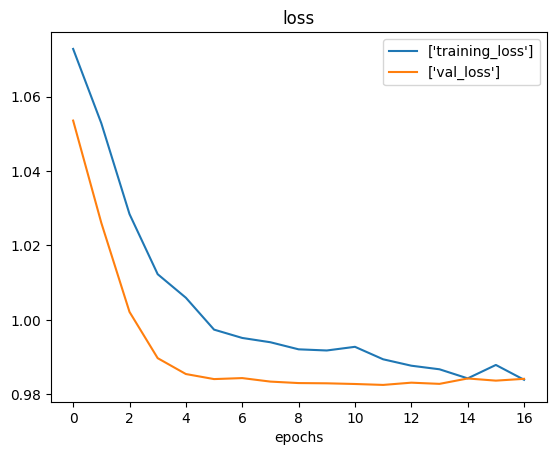

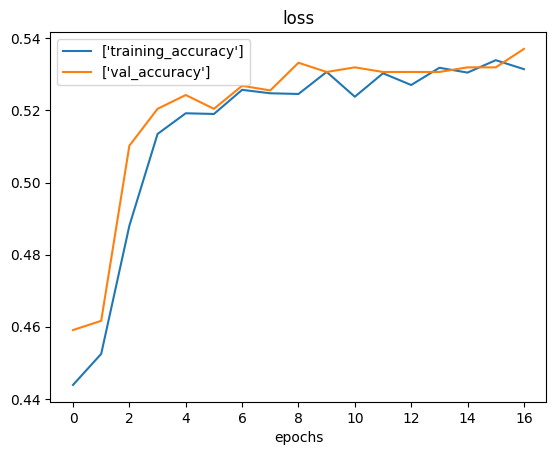

In [ ]:
plot_loss_curve(history_2_best)

In [ ]:
model_2_best.evaluate(Dataset_test_norm)

6/6 [==============================] - 0s 4ms/step - loss: 0.9768 - accuracy: 0.5484


[0.9768316745758057, 0.5483871102333069]

# Model_3: Conv1D

In [40]:
num_features = 'few'
num_giornate = 5
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, num_giornate).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, 
    Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, 
    Train_df, Valid_df, Test_df) = preprocess_features_time_series(df_Serie_A, num_features, random_state=False)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm,Test_labels_encoded )

utilizzando poche features
preprocess finished
utilizzando poche features
utilizzando poche features
utilizzando poche features


In [46]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)
model_3_best = create_time_series_model_conv1d(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, num_filters=12, 
                                               kernel_size=4, second_dropout=0.3, concat_dropout_1=0.5, concat_dropout_2=0.5,
                                                num_features=num_features )

# compile the model 
model_3_best.compile(
    loss = 'categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adamax()
    )

# fit the model
history_3_best = model_3_best.fit(
                Dataset_train_norm,
                epochs = 17,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                callbacks=[ 
                #create_model_checkpoint(model_name='model_1_time_series')
                # CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_1_dense', first_dropout=0.2, second_dropout=0.2,
                #                                         concat_dropout_1=0.5, concat_dropout_2=0.5, overwrite= False)
                ]
                )

Epoch 1/17
155/155 [==============================] - 4s 6ms/step - loss: 1.0778 - accuracy: 0.4306 - val_loss: 1.0568 - val_accuracy: 0.4649
Epoch 2/17
155/155 [==============================] - 1s 4ms/step - loss: 1.0611 - accuracy: 0.4468 - val_loss: 1.0391 - val_accuracy: 0.4649
Epoch 3/17
155/155 [==============================] - 1s 4ms/step - loss: 1.0438 - accuracy: 0.4571 - val_loss: 1.0222 - val_accuracy: 0.5135
Epoch 4/17
155/155 [==============================] - 1s 4ms/step - loss: 1.0242 - accuracy: 0.4877 - val_loss: 1.0102 - val_accuracy: 0.5311
Epoch 5/17
155/155 [==============================] - 1s 4ms/step - loss: 1.0158 - accuracy: 0.5070 - val_loss: 1.0041 - val_accuracy: 0.5230
Epoch 6/17
155/155 [==============================] - 1s 4ms/step - loss: 1.0122 - accuracy: 0.5094 - val_loss: 1.0000 - val_accuracy: 0.5270
Epoch 7/17
155/155 [==============================] - 1s 4ms/step - loss: 1.0012 - accuracy: 0.5179 - val_loss: 0.9970 - val_accuracy: 0.5243
Epoch 

## Evaluate

In [47]:
model_3_best.evaluate(Dataset_test_norm)

12/12 [==============================] - 0s 2ms/step - loss: 1.0136 - accuracy: 0.5054


[1.013600468635559, 0.5054054260253906]

0

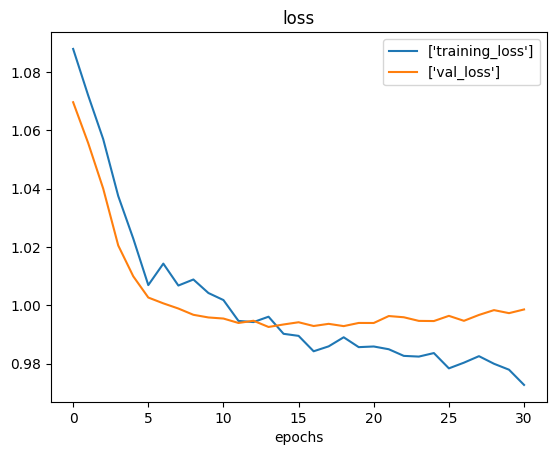

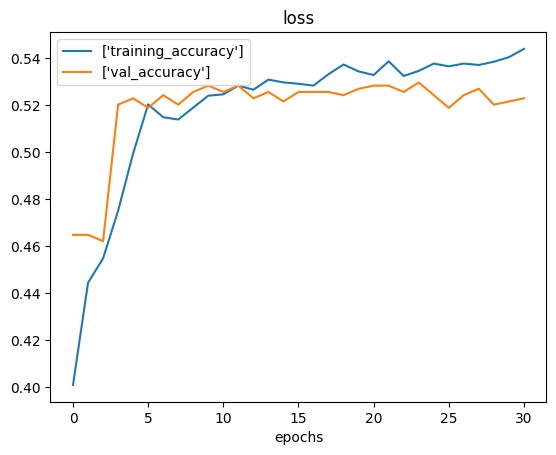

In [13]:
plot_loss_curve(history_3_best)

# Concatenating our model and bookmakers odds

## Preprocessing 

In [2]:
num_features = 'less'
num_giornate = 4
random_state = False
Statistiche_squadre_dict = preprocess_teams(dataframe = df_giornate)
df_Serie_A = create_time_series_features(num_features, Statistiche_squadre_dict, df_giornate, num_giornate).dropna()

(Train_teams_encoded, Valid_teams_encoded, Test_teams_encoded, Train_labels_encoded, Valid_labels_encoded, Test_labels_encoded, 
    Train_dict_features_norm, Valid_dict_features_norm, Test_dict_features_norm, Train_teams, Valid_teams, Test_teams, Train_labels, Valid_labels, 
    Test_labels, Train_dict_features, Valid_dict_features, Test_dict_features, Train_df, Valid_df, Test_df, Train_odds_norm, 
        Valid_odds_norm, Test_odds_norm) = preprocess_features_time_series_odds(df_Serie_A, num_features, random_state=random_state, save_tranformer=False)

feature_input_shape = Test_dict_features_norm[list(Test_dict_features_norm.keys())[0]].shape[1]
Train_teams_shape = Test_teams_encoded.shape[1]

Dataset_train_norm, Dataset_valid_norm, Dataset_test_norm = create_fast_preprocessing_ts_odds(Train_teams_encoded, Train_dict_features_norm, Train_labels_encoded,
                                                                                         Valid_teams_encoded, Valid_dict_features_norm,
                                                                    Valid_labels_encoded,Test_teams_encoded, Test_dict_features_norm, Test_labels_encoded, 
                                                                    Train_odds_norm, Valid_odds_norm, Test_odds_norm)

utilizzando meno features
preprocess finished
utilizzando meno features
utilizzando meno features
utilizzando meno features


## Bookmakers accuracy

In [3]:
len(Train_df), len(Valid_df), len(Test_df)

(5125, 740, 370)

Let's calculate the accuracy for the training, valid and test dataset that we're trying to beat

In [4]:
from sklearn.metrics import accuracy_score

conditions_1 = [
      ( (Train_df[f'home_win_odds'] <= Train_df['draw_odds']) & (Train_df[f'home_win_odds'] <= Train_df[f'away_win_odds'] )), 
      ( (Train_df['draw_odds'] <= Train_df[f'away_win_odds']) & (Train_df['draw_odds'] <= Train_df[f'home_win_odds'] )), 
      ( (Train_df[f'away_win_odds'] <= Train_df['draw_odds']) & (Train_df[f'away_win_odds'] <= Train_df[f'home_win_odds'] ))
      ]
values=['H','D','A']

predizioni_bookmakers =np.select(conditions_1, values)
risultati_effettivi = Valid_labels
print(f'train accuracy: {round(accuracy_score(predizioni_bookmakers, Train_labels),5)}')

train accuracy: 0.54244


In [5]:
from sklearn.metrics import accuracy_score

conditions_1 = [
      ( (Valid_df[f'home_win_odds'] <= Valid_df['draw_odds']) & (Valid_df[f'home_win_odds'] <= Valid_df[f'away_win_odds'] )), 
      ( (Valid_df['draw_odds'] <= Valid_df[f'away_win_odds']) & (Valid_df['draw_odds'] <= Valid_df[f'home_win_odds'] )), 
      ( (Valid_df[f'away_win_odds'] <= Valid_df['draw_odds']) & (Valid_df[f'away_win_odds'] <= Valid_df[f'home_win_odds'] ))
      ]
values=['H','D','A']

predizioni_bookmakers =np.select(conditions_1, values)
risultati_effettivi = Valid_labels
print(f'valid accuracy: {round(accuracy_score(predizioni_bookmakers, Valid_labels),5)}')

valid accuracy: 0.56081


In [6]:
from sklearn.metrics import accuracy_score

conditions_1 = [
      ( (Test_df[f'home_win_odds'] <= Test_df['draw_odds']) & (Test_df[f'home_win_odds'] <= Test_df[f'away_win_odds'] )), 
      ( (Test_df['draw_odds'] <= Test_df['away_win_odds']) & (Test_df['draw_odds'] <= Test_df[f'home_win_odds'] )), 
      ( (Test_df[f'away_win_odds'] <= Test_df['draw_odds']) & (Test_df[f'away_win_odds'] <= Test_df[f'home_win_odds'] ))
      ]
values=['H','D','A']

predizioni_bookmakers =np.select(conditions_1, values)
risultati_effettivi = Test_labels
print(f'test accuracy: {round(accuracy_score(predizioni_bookmakers, Test_labels),5)}')

test accuracy: 0.54324


## Compile and fit

In [7]:
#set the seed
tf.random.set_seed(42)
np.random.seed(42)
random.seed(12)

if random_state:
    model_4_best = create_time_series_model_odds(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, num_filters=12, 
                                                kernel_size=5, second_dropout=0.5, concat_dropout_1=0.6, concat_dropout_2=0.5,
                                                 num_features=num_features, odds_filters=8, odds_kernel=4, odds_dropout=0.2 )
else:
    model_4_best = create_time_series_model_odds(Train_teams_shape=Train_teams_shape, feature_input_shape=feature_input_shape, num_filters=16, 
                                               kernel_size=6, second_dropout=0.4, concat_dropout_1=0.5, concat_dropout_2=0.5,
                                                num_features=num_features, odds_filters=9, odds_kernel=6, odds_dropout=0.3  )

# compile the model 
model_4_best.compile(
    loss = 'categorical_crossentropy',
    metrics = 'accuracy',
    optimizer = tf.keras.optimizers.Adamax()
    )

# fit the model
history_4_best = model_4_best.fit(
                Dataset_train_norm,
                epochs = 34,
                verbose = 1,
                validation_data = Dataset_valid_norm,
                 callbacks=[ 
                # create_model_checkpoint(model_name='model_odds_time_series_best')
                #  CSVLoggerCallbackDropout('results_time_series_dropout.csv', 'model_concat', first_dropout=0.2, second_dropout=0.2,
                #                                           concat_dropout_1=0.5, concat_dropout_2=0.5, overwrite= True)
                 ]
                )

# Salva il modello
# tf.keras.models.save_model(model_4_best, r'c:\Users\Hp\Serie_A\model_experiments\model_odds_time_series')

Epoch 1/34
161/161 [==============================] - 4s 5ms/step - loss: 1.0771 - accuracy: 0.4367 - val_loss: 1.0644 - val_accuracy: 0.4649
Epoch 2/34
161/161 [==============================] - 1s 3ms/step - loss: 1.0723 - accuracy: 0.4488 - val_loss: 1.0582 - val_accuracy: 0.4649
Epoch 3/34
161/161 [==============================] - 1s 3ms/step - loss: 1.0612 - accuracy: 0.4523 - val_loss: 1.0486 - val_accuracy: 0.4649
Epoch 4/34
161/161 [==============================] - 1s 3ms/step - loss: 1.0514 - accuracy: 0.4558 - val_loss: 1.0396 - val_accuracy: 0.4770
Epoch 5/34
161/161 [==============================] - 1s 3ms/step - loss: 1.0409 - accuracy: 0.4661 - val_loss: 1.0292 - val_accuracy: 0.5095
Epoch 6/34
161/161 [==============================] - 1s 3ms/step - loss: 1.0349 - accuracy: 0.4827 - val_loss: 1.0221 - val_accuracy: 0.5162
Epoch 7/34
161/161 [==============================] - 1s 3ms/step - loss: 1.0213 - accuracy: 0.5032 - val_loss: 1.0118 - val_accuracy: 0.5095
Epoch 

The model obtained: 

![Il nostro modello:](model_odds.png)

In [8]:
model_4_best.evaluate(Dataset_test_norm)

12/12 [==============================] - 0s 2ms/step - loss: 0.9617 - accuracy: 0.5432


[0.9616929292678833, 0.5432432293891907]

# Money win

in this section we see if there are betting strategies that improve our winning chances

## Valid dataset 

In [9]:
# visualizing the results
model_4_pred_probs = model_4_best.predict((Dataset_valid_norm))
model_4_prob = model_4_pred_probs.max(axis=1)
model_4_predictions = model_4_pred_probs.argmax(axis=1)
model_4_compare = pd.DataFrame({
                                'stagione': list( Valid_df['stagione'] ),
                                'hometeam': list( Valid_df['hometeam'] ),
                                'awayteam': list( Valid_df['awayteam'] ),
                                'preds': model_4_predictions, 
                                'result': list(Valid_labels['ft_result']), 
                                'best_pred_prob': model_4_prob,
                                'home_win_odds': list( Valid_df['home_win_odds'] ),
                                'draw_odds': list( Valid_df['draw_odds'] ),
                                'away_win_odds': list( Valid_df['away_win_odds'])
                                })
model_4_compare['bookmakers_pred'] = np.argmin(Valid_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_4_compare['bookmakers_prob'] = np.nanmin(Valid_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assigning to the encoded values more intuitive values
conditions = [
(model_4_compare['preds'] == 2),  # Condition per Home Win
(model_4_compare['preds'] == 0),  # Condition per Away Win
(model_4_compare['preds'] == 1)   # Condition per draw
]
conditions_bookmakers = [
(model_4_compare['bookmakers_pred'] == 0),  # Condition per Home Win
(model_4_compare['bookmakers_pred'] == 2),  # Condition per Away Win
(model_4_compare['bookmakers_pred'] == 1)   # Condition per Draw
]

# conditions corresponding values
values = ['H', 'A', 'D']

# Creating 'result' e 'points' columns
model_4_compare['preds'] = np.select(conditions, values)
model_4_compare['bookmakers_pred'] = np.select(conditions_bookmakers, values)
model_4_compare['is_correct'] = model_4_compare['preds'] == model_4_compare['result']
# create money won column
model_4_compare['pred_odds'] = model_4_compare.apply(lambda row: row['home_win_odds'] if row['preds'] == 'H' else (row['draw_odds'] if row['preds'] == 'D' 
                                                                                             else row['away_win_odds']), axis=1)
model_4_compare['money_won'] = model_4_compare['best_pred_prob']*model_4_compare['pred_odds']

model_4_compare.sort_values(['money_won'],ascending=False).head(15)

24/24 [==============================] - 0s 2ms/step


,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won
162,2009/2010,Bologna,Lazio,A,A,0.466495,4.50,1.62,4.50,D,1.62,True,4.50,2.099226
308,2012/2013,Parma,Atalanta,A,H,0.364525,2.60,2.10,5.00,D,2.10,False,5.00,1.822623
696,2022/2023,Torino,Monza,A,D,0.444983,2.00,3.30,4.00,H,2.00,False,4.00,1.779932
98,2007/2008,Siena,Genoa,A,A,0.346723,2.62,2.05,5.00,D,2.05,True,5.00,1.733613
194,2009/2010,Cagliari,Udinese,A,D,0.353325,4.00,1.62,4.75,D,1.62,False,4.75,1.678293
235,2010/2011,Bologna,Parma,H,D,0.366868,4.50,1.40,6.50,D,1.40,False,4.50,1.650906
193,2009/2010,Bari,Genoa,A,H,0.404000,3.50,1.83,4.00,D,1.83,False,4.00,1.615999
138,2008/2009,Siena,Napoli,A,H,0.412019,2.15,3.00,3.60,H,2.15,False,3.60,1.483268
710,2022/2023,Sassuolo,Monza,A,A,0.459438,2.15,3.60,3.20,H,2.15,True,3.20,1.470201
50,2006/2007,Torino,Milan,A,A,0.584834,4.50,2.20,2.50,D,2.20,True,2.50,1.462084


### winning probability > 1

In [10]:
#money won
model_4_compare[(model_4_compare['is_correct']) & (model_4_compare['money_won']>1)]['pred_odds'].sum()

244.32

In [11]:
pd.set_option('display.max_columns', None)
# money spent
len(model_4_compare[(model_4_compare['money_won']>1)])

228

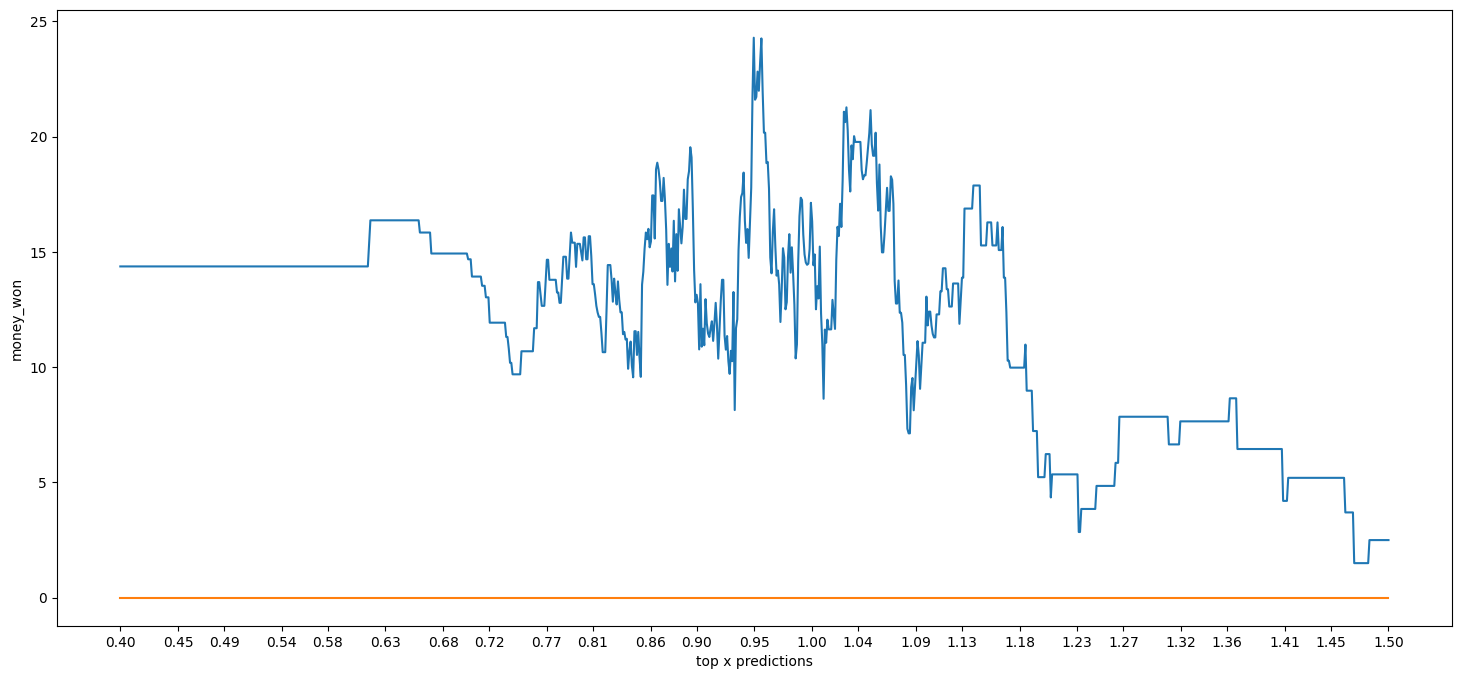

In [12]:
import matplotlib.pyplot as plt
## let's see it graphically
top_pred_list = []
money_won_list = []
for top_pred in np.linspace(0.4,1.5,1000):
    top_preds_df = model_4_compare[(model_4_compare['money_won']>top_pred)]
    top_wins_correct =  model_4_compare[(model_4_compare['money_won']>top_pred) & (model_4_compare['is_correct'])]
    money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)
    top_pred_list.append(top_pred)
    money_won_list.append(money_won)

plt.figure(figsize=(18, 8))
plt.plot(top_pred_list, money_won_list)
plt.plot(top_pred_list, np.zeros(1000))
plt.xlabel('top x predictions')
plt.ylabel('money_won')
plt.xticks(np.round(np.linspace(0.4,1.5,25),2))
plt.show()

### Better predictions than bookmakers 

In [13]:
model_4_compare[(model_4_compare['is_correct']) & (model_4_compare['bookmakers_pred']!=model_4_compare['result'])].sort_values(['best_pred_prob'], ascending=False).head(5)

,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won
50,2006/2007,Torino,Milan,A,A,0.584834,4.50,2.20,2.5,D,2.20,True,2.50,1.462084
162,2009/2010,Bologna,Lazio,A,A,0.466495,4.50,1.62,4.5,D,1.62,True,4.50,2.099226
710,2022/2023,Sassuolo,Monza,A,A,0.459438,2.15,3.60,3.2,H,2.15,True,3.20,1.470201
118,2007/2008,Atalanta,Livorno,H,H,0.433260,3.25,3.30,2.2,A,2.20,True,3.25,1.408095
5,2005/2006,Siena,Lazio,A,A,0.427794,2.80,2.20,3.2,D,2.20,True,3.20,1.368941


### Most recent predictions

In [14]:
model_4_compare.sort_values(['stagione'], ascending=False).head(8)

,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won
739,2023/2024,Empoli,Lecce,H,D,0.393465,2.55,3.20,3.00,H,2.55,False,2.55,1.003336
729,2023/2024,Torino,Atalanta,A,H,0.387754,2.90,3.20,2.45,A,2.45,False,2.45,0.949998
721,2023/2024,Milan,Frosinone,H,H,0.659735,1.44,4.50,7.50,H,1.44,True,1.44,0.950018
722,2023/2024,Lazio,Cagliari,H,H,0.623297,1.62,4.00,5.25,H,1.62,True,1.62,1.009741
723,2023/2024,Genoa,Empoli,H,D,0.499984,1.91,3.60,3.80,H,1.91,False,1.91,0.954970
724,2023/2024,Fiorentina,Salernitana,H,H,0.608605,1.45,4.75,7.00,H,1.45,True,1.45,0.882478
725,2023/2024,Lecce,Bologna,A,D,0.426099,3.00,3.20,2.45,A,2.45,False,2.45,1.043943
726,2023/2024,Napoli,Inter,A,A,0.381940,2.80,3.50,2.40,A,2.40,True,2.40,0.916656


### Top valid preds

In [15]:
top_money_won = 0
best_pred = 0
numero_partite_considerate = 0
for top_pred in np.linspace(0.5,1,50):
    top_preds_df = model_4_compare[(model_4_compare['best_pred_prob']>top_pred)]
    top_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']>top_pred) & (model_4_compare['is_correct'])]
    money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)

    if money_won > top_money_won:
        numero_partite_considerate = len(top_preds_df)
        top_money_won = money_won
        best_pred = top_pred

print(f'numero di partite con predizione superiore a  {best_pred}: {numero_partite_considerate} su {len(model_4_compare)} record totali')
print(f'la migliore vincita si ha per predizioni con probabilità > {best_pred}, con {top_money_won} euro vinti')

numero di partite con predizione superiore a  0.5612244897959183: 272 su 740 record totali
la migliore vincita si ha per predizioni con probabilità > 0.5612244897959183, con 9.559999999999945 euro vinti


In [16]:
worst_pred = model_4_compare[(model_4_compare['best_pred_prob'] < best_pred)]
worst_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']<best_pred) & (model_4_compare['is_correct'])]
worst_wins_correct['pred_odds'].sum() - len(worst_pred)

0.8100000000000591

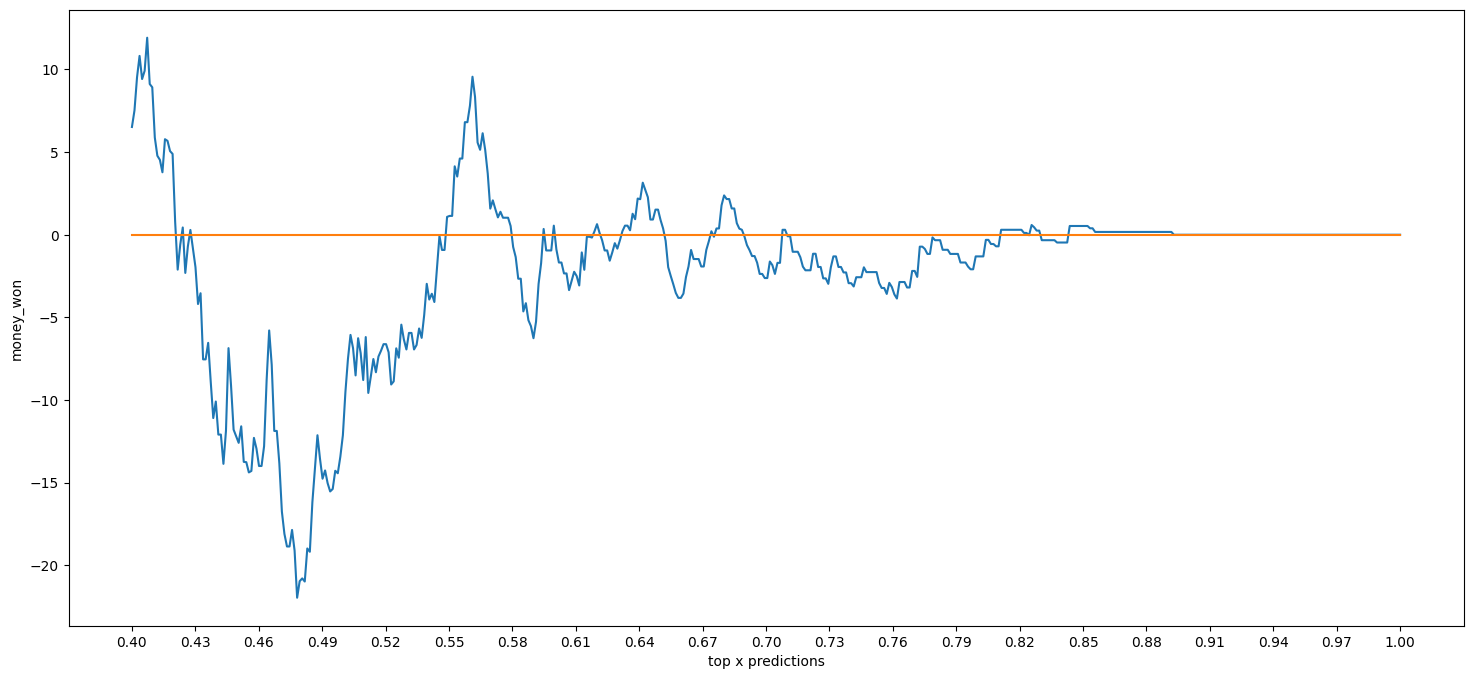

In [17]:
import matplotlib.pyplot as plt
## Vediamo graficamente i guadagni 
top_pred_list = []
money_won_list = []
for top_pred in np.linspace(0.4,1,500):
    top_preds_df = model_4_compare[(model_4_compare['best_pred_prob']>top_pred)]
    top_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']>top_pred) & (model_4_compare['is_correct'])]
    money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)
    top_pred_list.append(top_pred)
    money_won_list.append(money_won)

plt.figure(figsize=(18, 8))
plt.plot(top_pred_list, money_won_list)
plt.plot(top_pred_list, np.zeros(500))
plt.xlabel('top x predictions')
plt.ylabel('money_won')
plt.xticks(np.round(np.linspace(0.4,1,21),2))
plt.show()

### Pareggi

In [18]:
len(model_4_compare[(model_4_compare['result']=='D')]) / len(model_4_compare)

0.2391891891891892

### Winning prob >1 all

In [19]:
model_4_compare[['model_away_prob','model_draw_prob','model_home_prob']] = model_4_pred_probs
model_4_compare[['home_win_odds', 'draw_odds', 'away_win_odds']] = Valid_df[['home_win_odds', 'draw_odds', 'away_win_odds']].values
model_4_compare['money_won_home'] = model_4_compare['model_home_prob']*model_4_compare['home_win_odds']
model_4_compare['money_won_draw'] = model_4_compare['model_draw_prob']*model_4_compare['draw_odds']
model_4_compare['money_won_away'] = model_4_compare['model_away_prob']*model_4_compare['away_win_odds']
model_4_compare['hometeam1'] = model_4_compare['hometeam']
model_4_compare['awayteam1'] = model_4_compare['awayteam']


In [20]:
#money won
won_home = model_4_compare[(model_4_compare['result']=='H') & (model_4_compare['money_won_home']>1)]['home_win_odds'].sum()
#money won
won_draw = model_4_compare[(model_4_compare['result']=='D') & (model_4_compare['money_won_draw']>1)]['draw_odds'].sum()
#money won
won_away = model_4_compare[(model_4_compare['result']=='A') & (model_4_compare['money_won_away']>1)]['away_win_odds'].sum()

won_home + won_draw + won_away

663.97

In [21]:
loss_home =len(model_4_compare[(model_4_compare['money_won_home']>1)])
loss_draw = len(model_4_compare[(model_4_compare['money_won_draw']>1)])
loss_away = len(model_4_compare[(model_4_compare['money_won_away']>1)])
loss_home + loss_draw + loss_away

779

## Test dataset

In [22]:
# visualizing the results
model_4_pred_probs = model_4_best.predict((Dataset_test_norm))
model_4_prob = model_4_pred_probs.max(axis=1)
model_4_predictions = model_4_pred_probs.argmax(axis=1)
model_4_compare = pd.DataFrame({
                                'stagione': list( Test_df['stagione'] ),
                                'hometeam': list( Test_df['hometeam'] ),
                                'awayteam': list( Test_df['awayteam'] ),
                                'preds': model_4_predictions, 
                                'result': list(Test_labels['ft_result']), 
                                'best_pred_prob': model_4_prob,
                                'home_win_odds': list( Test_df['home_win_odds'] ),
                                'draw_odds': list( Test_df['draw_odds'] ),
                                'away_win_odds': list( Test_df['away_win_odds'])
                                })
model_4_compare['bookmakers_pred'] = np.argmin(Test_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)
model_4_compare['bookmakers_prob'] = np.nanmin(Test_df[['home_win_odds', 'draw_odds', 'away_win_odds']].fillna(0.0).to_numpy(), axis=1)

# Assigning to the encoded values more intuitive values
conditions = [
(model_4_compare['preds'] == 2),  # Condition per Home Win
(model_4_compare['preds'] == 0),  # Condition per Away Win
(model_4_compare['preds'] == 1)   # Condition per draw
]
conditions_bookmakers = [
(model_4_compare['bookmakers_pred'] == 0),  # Condition per Home Win
(model_4_compare['bookmakers_pred'] == 2),  # Condition per Away Win
(model_4_compare['bookmakers_pred'] == 1)   # Condition per Draw
]

# conditions corresponding values
values = ['H', 'A', 'D']

# Creating 'result' e 'points' columns
model_4_compare['preds'] = np.select(conditions, values)
model_4_compare['bookmakers_pred'] = np.select(conditions_bookmakers, values)
model_4_compare['is_correct'] = model_4_compare['preds'] == model_4_compare['result']
# create money won column
model_4_compare['pred_odds'] = model_4_compare.apply(lambda row: row['home_win_odds'] if row['preds'] == 'H' else (row['draw_odds'] if row['preds'] == 'D' 
                                                                                             else row['away_win_odds']), axis=1)
model_4_compare['money_won'] = model_4_compare['best_pred_prob']*model_4_compare['pred_odds']

model_4_compare.sort_values(['money_won'],ascending=False).head(15)

12/12 [==============================] - 0s 2ms/step


,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won
110,2010/2011,Udinese,Milan,A,D,0.469438,3.50,1.53,6.50,D,1.53,False,6.50,3.051347
66,2008/2009,Chievo,Bologna,A,D,0.375309,3.20,1.57,6.00,D,1.57,False,6.00,2.251852
39,2006/2007,Livorno,Atalanta,A,H,0.423231,2.40,2.40,4.00,H,2.40,False,4.00,1.692926
29,2006/2007,Torino,Livorno,H,D,0.519832,3.25,1.40,11.00,D,1.40,False,3.25,1.689452
104,2010/2011,Napoli,Inter,A,D,0.418723,3.80,1.75,3.80,D,1.75,False,3.80,1.591147
4,2005/2006,Livorno,Sampdoria,A,D,0.389834,2.40,2.40,4.00,H,2.40,False,4.00,1.559334
25,2006/2007,Lazio,Parma,H,D,0.402488,3.60,2.40,2.62,D,2.40,False,3.60,1.448957
154,2012/2013,Inter,Udinese,H,A,0.422628,3.25,3.50,2.10,A,2.10,False,3.25,1.373541
233,2016/2017,Crotone,Lazio,A,H,0.408625,2.05,4.00,3.25,H,2.05,False,3.25,1.328031
50,2007/2008,Sampdoria,Juventus,A,D,0.405027,2.37,3.00,3.20,H,2.37,False,3.20,1.296087


### winning probability >1 

In [23]:
len(model_4_compare)

370

In [24]:
#soldi vinti
model_4_compare[(model_4_compare['is_correct']) & (model_4_compare['money_won']>1)]['pred_odds'].sum()

92.29

In [25]:
pd.set_option('display.max_columns', None)

len(model_4_compare[(model_4_compare['money_won']>1)])

104

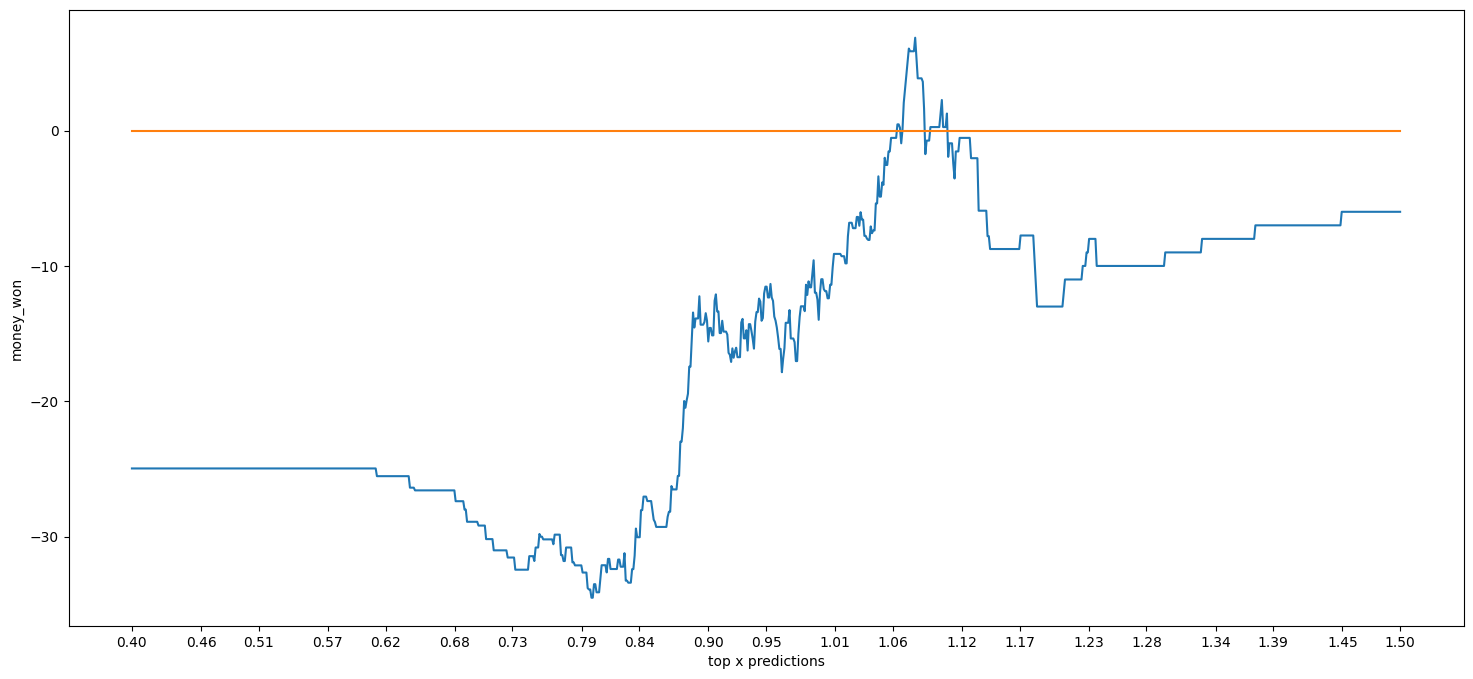

In [26]:
import matplotlib.pyplot as plt
## Vediamo graficamente i guadagni 
top_pred_list = []
money_won_list = []
for top_pred in np.linspace(0.4,1.5,1000):
    top_preds_df = model_4_compare[(model_4_compare['money_won']>top_pred)]
    top_wins_correct =  model_4_compare[(model_4_compare['money_won']>top_pred) & (model_4_compare['is_correct'])]
    money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)
    top_pred_list.append(top_pred)
    money_won_list.append(money_won)

plt.figure(figsize=(18, 8))
plt.plot(top_pred_list, money_won_list)
plt.plot(top_pred_list, np.zeros(1000))
plt.xlabel('top x predictions')
plt.ylabel('money_won')
plt.xticks(np.round(np.linspace(0.4,1.5,21),2))
plt.show()

### Better predictions than bookmakers 

In [27]:
model_4_compare[(model_4_compare['is_correct']) & (model_4_compare['bookmakers_pred']!=model_4_compare['result'])].sort_values(['best_pred_prob'], ascending=False)

,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won
342,2022/2023,Salernitana,Udinese,H,H,0.438314,2.70,3.50,2.55,A,2.55,True,2.70,1.183447
318,2020/2021,Atalanta,Milan,A,A,0.431812,2.37,4.20,2.50,H,2.37,True,2.50,1.079529
37,2006/2007,Catania,Chievo,H,H,0.430083,2.75,2.87,2.70,A,2.70,True,2.75,1.182727
28,2006/2007,Sampdoria,Catania,H,H,0.423127,2.80,3.10,2.50,A,2.50,True,2.80,1.184756
9,2005/2006,Ascoli,Lazio,A,A,0.411914,2.87,2.50,3.00,D,2.50,True,3.00,1.235742
78,2008/2009,Fiorentina,Milan,A,A,0.396427,2.50,3.10,2.88,H,2.50,True,2.88,1.141710
130,2011/2012,Catania,Udinese,A,A,0.393600,4.00,2.15,2.88,D,2.15,True,2.88,1.133567
353,2022/2023,Torino,Inter,A,A,0.378107,2.30,3.50,3.00,H,2.30,True,3.00,1.134321
300,2020/2021,Roma,Lazio,H,H,0.367649,3.00,3.60,2.25,A,2.25,True,3.00,1.102948
181,2014/2015,Juventus,Napoli,H,H,0.362187,3.00,3.30,2.40,A,2.40,True,3.00,1.086560


### Top Test preds

In [28]:
top_money_won = 0
best_pred = 0
numero_partite_considerate = 0
for top_pred in np.linspace(0.5,1,50):
    top_preds_df = model_4_compare[(model_4_compare['best_pred_prob']>top_pred)]
    top_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']>top_pred) & (model_4_compare['is_correct'])]
    money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)

    if money_won > top_money_won:
        numero_partite_considerate = len(top_preds_df)
        top_money_won = money_won
        best_pred = top_pred

print(f'numero di partite con predizione superiore a  {best_pred}: {numero_partite_considerate} su {len(model_4_compare)} record totali')
print(f'la migliore vincita si ha per predizioni con probabilità > {best_pred}, con {top_money_won} euro vinti')

numero di partite con predizione superiore a  0.6224489795918368: 103 su 370 record totali
la migliore vincita si ha per predizioni con probabilità > 0.6224489795918368, con 4.739999999999995 euro vinti


In [29]:
worst_pred = model_4_compare[(model_4_compare['best_pred_prob'] < best_pred)]
worst_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']<best_pred) & (model_4_compare['is_correct'])]
worst_wins_correct['pred_odds'].sum() - len(worst_pred)

-30.700000000000017

In [30]:
## Vediamo quanto si guadagnerebbe scegliendo 0.6 come best pred
top_pred = 0.64
top_preds_df = model_4_compare[(model_4_compare['best_pred_prob']>top_pred)]
top_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']>top_pred) & (model_4_compare['is_correct'])]
money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)
money_won

3.960000000000008

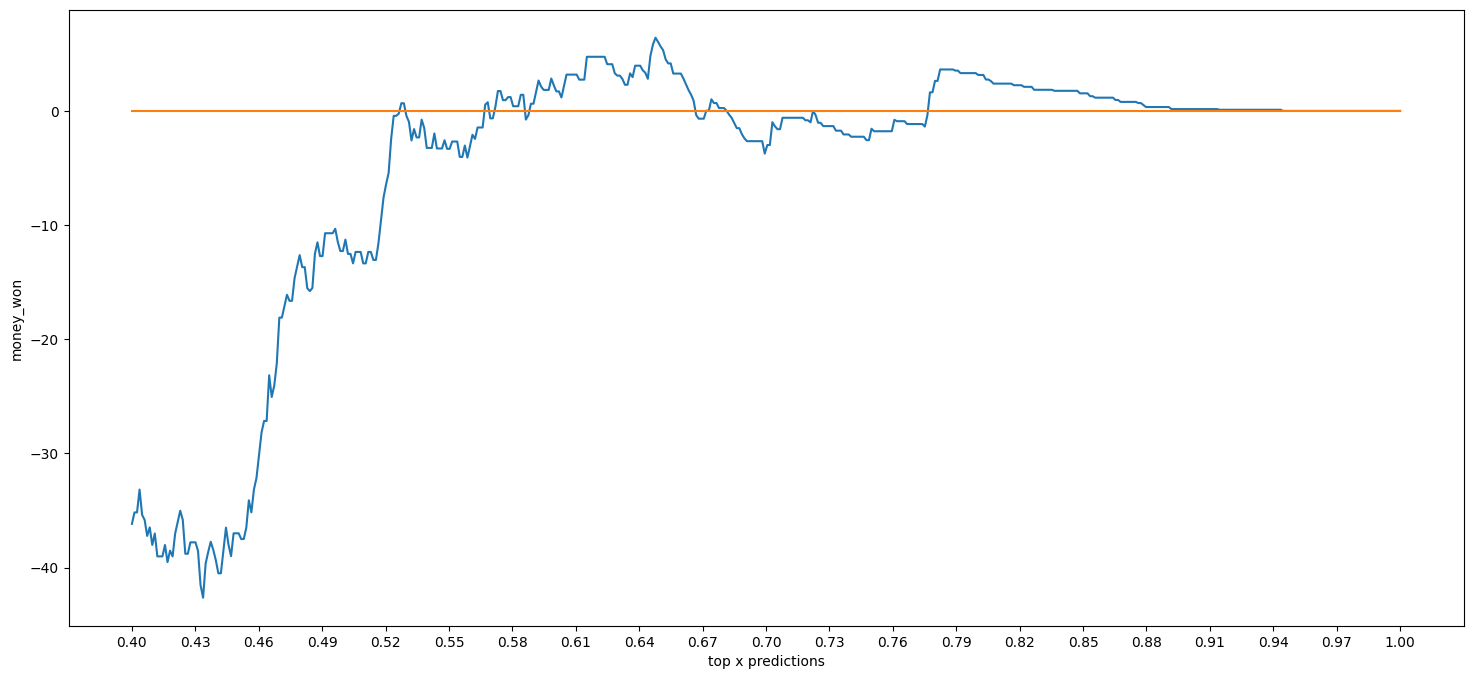

In [31]:
import matplotlib.pyplot as plt
## Vediamo graficamente i guadagni 
top_pred_list = []
money_won_list = []
for top_pred in np.linspace(0.4,1,500):
    top_preds_df = model_4_compare[(model_4_compare['best_pred_prob']>top_pred)]
    top_wins_correct =  model_4_compare[(model_4_compare['best_pred_prob']>top_pred) & (model_4_compare['is_correct'])]
    money_won = top_wins_correct['pred_odds'].sum() - len(top_preds_df)
    top_pred_list.append(top_pred)
    money_won_list.append(money_won)

plt.figure(figsize=(18, 8))
plt.plot(top_pred_list, money_won_list)
plt.plot(top_pred_list, np.zeros(500))
plt.xlabel('top x predictions')
plt.ylabel('money_won')
plt.xticks(np.round(np.linspace(0.4,1,21),2))
plt.show()

### Different ersults from bookmakers

In [32]:
model_4_compare[(model_4_compare['bookmakers_pred']!=model_4_compare['preds'])].sort_values(['best_pred_prob'], ascending=False)

,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won
29,2006/2007,Torino,Livorno,H,D,0.519832,3.25,1.40,11.00,D,1.40,False,3.25,1.689452
110,2010/2011,Udinese,Milan,A,D,0.469438,3.50,1.53,6.50,D,1.53,False,6.50,3.051347
24,2006/2007,Empoli,Reggina,A,D,0.461077,3.40,2.50,2.62,D,2.50,False,2.62,1.208021
292,2019/2020,Juventus,Roma,H,A,0.454694,2.70,4.20,2.20,A,2.20,False,2.70,1.227673
342,2022/2023,Salernitana,Udinese,H,H,0.438314,2.70,3.50,2.55,A,2.55,True,2.70,1.183447
14,2005/2006,Treviso,Udinese,A,H,0.435285,3.80,2.30,2.40,D,2.30,False,2.40,1.044684
10,2005/2006,Siena,Livorno,H,D,0.434846,2.30,2.25,4.20,D,2.25,False,2.30,1.000147
318,2020/2021,Atalanta,Milan,A,A,0.431812,2.37,4.20,2.50,H,2.37,True,2.50,1.079529
37,2006/2007,Catania,Chievo,H,H,0.430083,2.75,2.87,2.70,A,2.70,True,2.75,1.182727
39,2006/2007,Livorno,Atalanta,A,H,0.423231,2.40,2.40,4.00,H,2.40,False,4.00,1.692926


### Pareggi 

In [33]:
len(model_4_compare[(model_4_compare['result']=='D')]) / len(model_4_compare)

0.23513513513513515

In [34]:
model_4_compare[(model_4_compare['result']=='D') & (model_4_compare['is_correct']==True)]

,stagione,hometeam,awayteam,preds,result,best_pred_prob,home_win_odds,draw_odds,away_win_odds,bookmakers_pred,bookmakers_prob,is_correct,pred_odds,money_won


### Money won > 1 all

In [35]:
model_4_compare[['model_away_prob','model_draw_prob','model_home_prob']] = model_4_pred_probs
model_4_compare[['home_win_odds', 'draw_odds', 'away_win_odds']] = Test_df[['home_win_odds', 'draw_odds', 'away_win_odds']].values
model_4_compare['money_won_home'] = model_4_compare['model_home_prob']*model_4_compare['home_win_odds']
model_4_compare['money_won_draw'] = model_4_compare['model_draw_prob']*model_4_compare['draw_odds']
model_4_compare['money_won_away'] = model_4_compare['model_away_prob']*model_4_compare['away_win_odds']
model_4_compare['hometeam1'] = model_4_compare['hometeam']
model_4_compare['awayteam1'] = model_4_compare['awayteam']

#money won
won_home = model_4_compare[(model_4_compare['result']=='H') & (model_4_compare['money_won_home']>1)]['home_win_odds'].sum()
#money won
won_draw = model_4_compare[(model_4_compare['result']=='D') & (model_4_compare['money_won_draw']>1)]['draw_odds'].sum()
#money won
won_away = model_4_compare[(model_4_compare['result']=='A') & (model_4_compare['money_won_away']>1)]['away_win_odds'].sum()

won_home + won_draw + won_away

319.08000000000004

In [36]:
loss_home =len(model_4_compare[(model_4_compare['money_won_home']>1)])
loss_draw = len(model_4_compare[(model_4_compare['money_won_draw']>1)])
loss_away = len(model_4_compare[(model_4_compare['money_won_away']>1)])
loss_home + loss_draw + loss_away

432